In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

#########################################
# Function: load_data
#########################################
def load_data(train_path='train.csv', store_path='store.csv'):
    """
    Loads the Rossmann train and store datasets.
    """
    train = pd.read_csv(train_path, parse_dates=['Date'])
    store = pd.read_csv(store_path)
    return train, store

In [2]:
#########################################
# Function: merge_data
#########################################
def merge_data(train, store):
    """
    Merges train and store data on 'Store'.
    """
    df = pd.merge(train, store, on='Store', how='left')
    return df

#########################################
# Function: preprocess_data
#########################################
def preprocess_data(df):
    """
    Basic cleaning:
      - Remove rows with Sales==0 (if Sales exists).
      - Fill missing values.
    """
    if 'Sales' in df.columns:
        df = df[df['Sales'] > 0].copy()

    df['CompetitionDistance'].fillna(df['CompetitionDistance'].max(), inplace=True)
    df['CompetitionOpenSinceYear'].fillna(df['Date'].dt.year, inplace=True)
    df['CompetitionOpenSinceMonth'].fillna(df['Date'].dt.month, inplace=True)
    df['Promo2SinceWeek'].fillna(0, inplace=True)
    df['Promo2SinceYear'].fillna(0, inplace=True)
    df['PromoInterval'].fillna("None", inplace=True)
    return df

In [3]:
#########################################
# Function: feature_engineering
#########################################
def feature_engineering(df):
    """
    Creates new features:
      - Date-based features (year, month, day, week-of-year, day-of-week, day-of-year).
      - Cyclical features for day-of-week and month.
      - Aggregated store-level features (if Sales exists).
      - Competition open since (combining year and month).
      - Promo2 duration feature.
      - Log-transform of Sales (if Sales exists).
      - One-hot encoding for categorical columns.
    """
    # Date features
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['DayOfWeek'] = df['Date'].dt.dayofweek  # Monday=0, Sunday=6
    df['DayOfYear'] = df['Date'].dt.dayofyear
    df['IsWeekend'] = df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

    # Cyclical features
    df['DayOfWeek_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
    df['DayOfWeek_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)
    df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
    df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

    # Competition open since (combine year and month)
    df['CompetitionOpenSince'] = (df['CompetitionOpenSinceYear'].astype(int) * 100 +
                                  df['CompetitionOpenSinceMonth'].astype(int))

    # Promo2 duration features
    if 'Promo2' in df.columns:
        df['Promo2Active'] = df['Promo2'].apply(lambda x: 1 if x == 1 else 0)
        df['Promo2SinceYear'] = df['Promo2SinceYear'].fillna(0).astype(int)
        df['Promo2SinceWeek'] = df['Promo2SinceWeek'].fillna(0).astype(int)
        df['Promo2Since'] = df.apply(lambda row: (row['Year'] - row['Promo2SinceYear']) * 12 +
                                              (row['Month'] - ((row['Promo2SinceWeek'] // 4) + 1))
                                      if row['Promo2Active'] == 1 and row['Promo2SinceYear'] > 0 else 0, axis=1)
    else:
        df['Promo2Since'] = 0

    # Compute LogSales only if Sales exists
    if 'Sales' in df.columns:
        df['LogSales'] = np.log1p(df['Sales'])

    # One-hot encoding for categorical features (if present)
    for col in ['StateHoliday', 'StoreType', 'Assortment']:
        if col in df.columns:
            df = pd.get_dummies(df, columns=[col], drop_first=True)

    return df

In [4]:
#########################################
# Function: compute_store_aggregates
#########################################
def compute_store_aggregates(df):
    """
    Computes store-level aggregated features from the training data.
    Returns a DataFrame with aggregated features by Store.
    """
    agg = df.groupby('Store')['Sales'].agg(['mean', 'std', 'median']).reset_index()
    agg.rename(columns={'mean': 'Store_MeanSales',
                        'std': 'Store_StdSales',
                        'median': 'Store_MedianSales'}, inplace=True)
    return agg

In [5]:
#########################################
# Function: eda
#########################################
def eda(df):
    """
    Generates plots to explore the data.
    """
    plt.figure(figsize=(10, 5))
    sns.histplot(df['Sales'], bins=50, kde=True)
    plt.title("Distribution of Sales")
    plt.xlabel("Sales")
    plt.ylabel("Frequency")
    plt.show()

    # Time series for a sample store (store 1)
    store1 = df[df['Store'] == 1].sort_values(by='Date')
    plt.figure(figsize=(12, 5))
    plt.plot(store1['Date'], store1['Sales'], marker='o', linestyle='-', markersize=3)
    plt.title("Store 1 Sales Over Time")
    plt.xlabel("Date")
    plt.ylabel("Sales")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Correlation heatmap
    plt.figure(figsize=(12, 10))
    numeric_cols = df.select_dtypes(include=['int64','float64']).columns
    corr = df[numeric_cols].corr()
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
    plt.title("Correlation Heatmap")
    plt.show()

In [6]:
#########################################
# Function: train_model
#########################################
def train_model(X_train, y_train):
    """
    Trains an XGBoost regressor using GridSearchCV.
    """
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 5],
        'learning_rate': [0.05, 0.1],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }
    grid = GridSearchCV(estimator=xgb_model, param_grid=param_grid,
                        scoring='neg_root_mean_squared_error', cv=3, verbose=1)
    grid.fit(X_train, y_train)
    print("Best parameters found:", grid.best_params_)
    print("Best RMSE (negative):", grid.best_score_)
    best_model = grid.best_estimator_
    return best_model

In [7]:
#########################################
# Function: evaluate_model
#########################################
def evaluate_model(model, X_test, y_test):
    """
    Evaluates the model on internal test data.
    """
    predictions = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    mae = mean_absolute_error(y_test, predictions)
    mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100

    print("Internal Test Evaluation Metrics:")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"MAPE: {mape:.2f}%")

    plt.figure(figsize=(8,6))
    plt.scatter(y_test, predictions, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel("Actual Log Sales")
    plt.ylabel("Predicted Log Sales")
    plt.title("Actual vs. Predicted Log Sales (Internal Test)")
    plt.show()

In [8]:
#########################################
# Main function
#########################################
def main():
    """
    Executes the full pipeline:
      1. Load and merge training and store data.
      2. Preprocess and feature engineer.
      3. Compute store-level aggregate features from training data.
      4. Perform EDA.
      5. Prepare features (dropping 'Customers') and train the XGBoost model with hyperparameter tuning.
      6. Evaluate on the internal test set.
      7. Load external test data, merge with store data and store aggregates, and evaluate using the trained model.
    """
    # 1. Load train and store data
    train, store = load_data()
    print("Train and Store data loaded.")

    # 2. Merge train and store data
    df = merge_data(train, store)
    print("Merged training data shape:", df.shape)

    # 3. Preprocess and feature engineer training data
    df = preprocess_data(df)
    df = feature_engineering(df)
    print("Preprocessing and Feature Engineering completed. New shape:", df.shape)

    # 4. Compute store-level aggregates from training data
    store_aggs = compute_store_aggregates(df)
    print("Computed store-level aggregates.")

    # 5. Perform EDA
    eda(df)

    # 6. Prepare features for modeling (target = LogSales)
    # Drop unnecessary columns including 'Customers'
    drop_cols = ['Id', 'Sales', 'Date', 'LogSales', 'Customers']
    features = df.drop(columns=[col for col in drop_cols if col in df.columns], errors='ignore')
    features = features.select_dtypes(include=[np.number])
    X = features
    y = df['LogSales']

    # Split into training and internal test sets (80/20)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print("Data split into training and internal testing sets.")

    # 7. Train the XGBoost model with hyperparameter tuning
    print("Training the XGBoost model...")
    model = train_model(X_train, y_train)

    # 8. Evaluate on the internal test set
    print("Evaluating model on internal test set...")
    evaluate_model(model, X_test, y_test)

    model.save_model('xgb_rossmann_model.json')
    print("Model saved to xgb_rossmann_model.json")

    # # Evaluate on the external test set from test.csv
    # print("Evaluating model on external test.csv...")
    # evaluate_external_test(model, test_csv_path='test.csv', store_csv_path='store.csv')

    print("Pipeline completed.")



In [9]:
# main()

FileNotFoundError: [Errno 2] No such file or directory: 'train.csv'

In [ ]:
def load_and_evaluate_external():
    """
    Loads a previously trained XGBoost model and evaluates it on external test set.
    """
    # Load model
    model = xgb.XGBRegressor()
    model.load_model('xgb_rossmann_model.json')
    print("Model loaded from xgb_rossmann_model.json")
    return model

In [ ]:
model = load_and_evaluate_external()

In [ ]:
def evaluate_test_data(model, merged_test_df):
    """
    Evaluates the external test dataframe (already merged with store data)
    using the trained model.

    This function applies the same preprocessing and feature engineering steps
    as used in training. It then drops columns that are not used for prediction
    (including 'Customers', since it is not available in future data) and returns
    model predictions.

    Args:
      model: Trained XGBoost model.
      merged_test_df (DataFrame): Merged test data (test.csv merged with store.csv).

    Returns:
      preds (ndarray): Model predictions.
    """
    # Apply the same preprocessing and feature engineering
    test_clean = preprocess_data(merged_test_df)
    test_fe = feature_engineering(test_clean)

    # Build the list of columns to drop from test data;
    # note: we drop 'Id', 'Date', 'Sales', 'LogSales', and importantly 'Customers'
    drop_cols = ['Id', 'Sales', 'Date', 'LogSales', 'Customers']
    X_test = test_fe.drop(columns=[col for col in drop_cols if col in test_fe.columns], errors='ignore')

    # Ensure only numeric features are used (and the order of columns matches training)
    X_test = X_test.select_dtypes(include=[np.number])

    # Get predictions from the model
    preds = model.predict(X_test)

    predictions = model.predict(X_test)
    return preds

In [ ]:
print("Loading and merging external test data...")
test_df = pd.read_csv('test.csv', parse_dates=['Date'])
store = pd.read_csv('store.csv')
external_merged = pd.merge(test_df, store, on='Store', how='left')

In [ ]:
print("Evaluating external test data...")
evaluate_test_data(model, external_merged)

In [ ]:
# prompt: create submission.csv with the same formatting as sample_submission using the pred array returned from the evaluate_test_data function from the last cell

import pandas as pd
import numpy as np

# Assuming 'evaluate_test_data' and 'external_merged' are defined from the previous cell
pred = evaluate_test_data(model, external_merged)

# Create a DataFrame for submission
submission_df = pd.DataFrame({'Id': external_merged['Id'], 'Sales': np.expm1(pred)})

# Save to submission.csv
submission_df.to_csv('submission.csv', index=False)


In [ ]:
# prompt: verify that the data in submission_new.csv is in the specified format Your submission should be a CSV file with 41088 rows and a header.

import pandas as pd

def verify_submission_format(filepath):
  """
  Verifies the format of the submission CSV file.

  Args:
    filepath: The path to the submission CSV file.

  Returns:
    True if the file meets the format requirements, False otherwise.
  """
  try:
    submission_df = pd.read_csv(filepath)
    if len(submission_df) == 41088 and 'Id' in submission_df.columns and 'Sales' in submission_df.columns:
      print("Submission file format is correct.")
      return True
    else:
      print("Error: Incorrect number of rows or missing columns in submission file.")
      return False
  except FileNotFoundError:
    print(f"Error: File '{filepath}' not found.")
    return False
  except pd.errors.EmptyDataError:
    print(f"Error: File '{filepath}' is empty.")
    return False
  except pd.errors.ParserError:
    print(f"Error: Unable to parse '{filepath}'. Check if it is a valid CSV.")
    return False


# Example usage:
is_valid = verify_submission_format('submission_new.csv')


In [13]:
from scipy.stats import hmean

def safe_hmean(x):
    """Compute harmonic mean safely: return NaN if any value is zero or negative."""
    x = np.array(x)
    if np.any(x <= 0):
        return np.nan
    else:
        return hmean(x)

def feature_engineering_new(df):
    """
    Enrich the dataframe with engineered features.

    Three main groups of features are created:
      1. Recent data features (if Sales exists): For each store, compute rolling statistics
         (mean, median, std, skewness, kurtosis, harmonic mean) over the past 30 days,
         and derive a trend feature (current Sales minus recent mean).
      2. Temporal information: Extract date components and create cyclical representations.
      3. Current trends & competition: Compute a combined "CompetitionOpenSince" feature and
         process promotion duration.

    Also, the target is log-transformed (if Sales exists) and categorical columns are one-hot encoded.

    Args:
      df (DataFrame): Input dataframe (with a Date column, and Sales if available).

    Returns:
      df (DataFrame): DataFrame with new engineered features.
    """
    # --- Recent Data Features ---
    # Only calculate if Sales exists (i.e. on training data)
    if 'Sales' in df.columns:
        # Ensure data is sorted by Store and Date
        df = df.sort_values(by=['Store', 'Date'])
        # Rolling window of 30 days per store (minimum 1 observation)
        df['Recent_Mean_30'] = df.groupby('Store')['Sales'].transform(lambda x: x.rolling(window=30, min_periods=1).mean())
        df['Recent_Median_30'] = df.groupby('Store')['Sales'].transform(lambda x: x.rolling(window=30, min_periods=1).median())
        df['Recent_Std_30'] = df.groupby('Store')['Sales'].transform(lambda x: x.rolling(window=30, min_periods=1).std())
        df['Recent_Skew_30'] = df.groupby('Store')['Sales'].transform(
            lambda x: x.rolling(window=30, min_periods=1).apply(lambda y: pd.Series(y).skew(), raw=False))
        df['Recent_Kurt_30'] = df.groupby('Store')['Sales'].transform(
            lambda x: x.rolling(window=30, min_periods=1).apply(lambda y: pd.Series(y).kurt(), raw=False))
        df['Recent_HarmonicMean_30'] = df.groupby('Store')['Sales'].transform(
            lambda x: x.rolling(window=30, min_periods=1).apply(safe_hmean, raw=True))
        # Trend: difference between current sales and the recent 30-day mean
        df['Trend_30'] = df['Sales'] - df['Recent_Mean_30']

    # --- Temporal Information Features ---
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['DayOfWeek'] = df['Date'].dt.dayofweek  # Monday=0, Sunday=6
    df['DayOfYear'] = df['Date'].dt.dayofyear
    df['IsWeekend'] = df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

    # Create cyclical representations
    df['DayOfWeek_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
    df['DayOfWeek_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)
    df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
    df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

    # --- Current Trends & Competition Features ---
    # Combine CompetitionOpenSinceYear and CompetitionOpenSinceMonth into a single numeric feature.
    df['CompetitionOpenSince'] = (df['CompetitionOpenSinceYear'].astype(int) * 100 +
                                  df['CompetitionOpenSinceMonth'].astype(int))

    # Promo2 duration features
    if 'Promo2' in df.columns:
        df['Promo2Active'] = df['Promo2'].apply(lambda x: 1 if x == 1 else 0)
        df['Promo2SinceYear'] = df['Promo2SinceYear'].fillna(0).astype(int)
        df['Promo2SinceWeek'] = df['Promo2SinceWeek'].fillna(0).astype(int)
        df['Promo2Since'] = df.apply(lambda row: (row['Year'] - row['Promo2SinceYear']) * 12 +
                                              (row['Month'] - ((row['Promo2SinceWeek'] // 4) + 1))
                                      if row['Promo2Active'] == 1 and row['Promo2SinceYear'] > 0 else 0, axis=1)
    else:
        df['Promo2Since'] = 0

    # --- Target Transformation ---
    if 'Sales' in df.columns:
        df['LogSales'] = np.log1p(df['Sales'])

    # --- Categorical Encoding ---
    for col in ['StateHoliday', 'StoreType', 'Assortment']:
        if col in df.columns:
            df = pd.get_dummies(df, columns=[col], drop_first=True)

    return df


In [14]:
#########################################
# Main function
#########################################
def main():
    """
    Executes the full pipeline:
      1. Load and merge training and store data.
      2. Preprocess and feature engineer.
      3. Compute store-level aggregate features from training data.
      4. Perform EDA.
      5. Prepare features (dropping 'Customers') and train the XGBoost model with hyperparameter tuning.
      6. Evaluate on the internal test set.
      7. Load external test data, merge with store data and store aggregates, and evaluate using the trained model.
    """
    # 1. Load train and store data
    train, store = load_data()
    print("Train and Store data loaded.")

    # 2. Merge train and store data
    df = merge_data(train, store)
    print("Merged training data shape:", df.shape)

    # 3. Preprocess and feature engineer training data
    df = preprocess_data(df)
    df = feature_engineering_new(df)
    print("Preprocessing and Feature Engineering completed. New shape:", df.shape)

    # 4. Compute store-level aggregates from training data
    store_aggs = compute_store_aggregates(df)
    print("Computed store-level aggregates.")

    # 5. Perform EDA
    eda(df)

    # 6. Prepare features for modeling (target = LogSales)
    # Drop unnecessary columns including 'Customers'
    drop_cols = ['Id', 'Sales', 'Date', 'LogSales', 'Customers', 'Recent_HarmonicMean_30','Recent_Mean_30', 'Recent_Skew_30', 'Recent_Median_30', 'Recent_Std_30', 'Recent_Kurt_30', 'Trend_30']
    features = df.drop(columns=[col for col in drop_cols if col in df.columns], errors='ignore')
    features = features.select_dtypes(include=[np.number])
    X = features
    y = df['LogSales']

    # Split into training and internal test sets (80/20)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print("Data split into training and internal testing sets.")

    # 7. Train the XGBoost model with hyperparameter tuning
    print("Training the XGBoost model...")
    model = train_model(X_train, y_train)

    # 8. Evaluate on the internal test set
    print("Evaluating model on internal test set...")
    evaluate_model(model, X_test, y_test)

    model.save_model('xgb_rossmann_model_new.json')
    print("Model saved to xgb_rossmann_model.json")

    # # Evaluate on the external test set from test.csv
    # print("Evaluating model on external test.csv...")
    # evaluate_external_test(model, test_csv_path='test.csv', store_csv_path='store.csv')

    print("Pipeline completed.")



Train and Store data loaded.
Merged training data shape: (1017209, 18)
Preprocessing and Feature Engineering completed. New shape: (844338, 45)
Computed store-level aggregates.


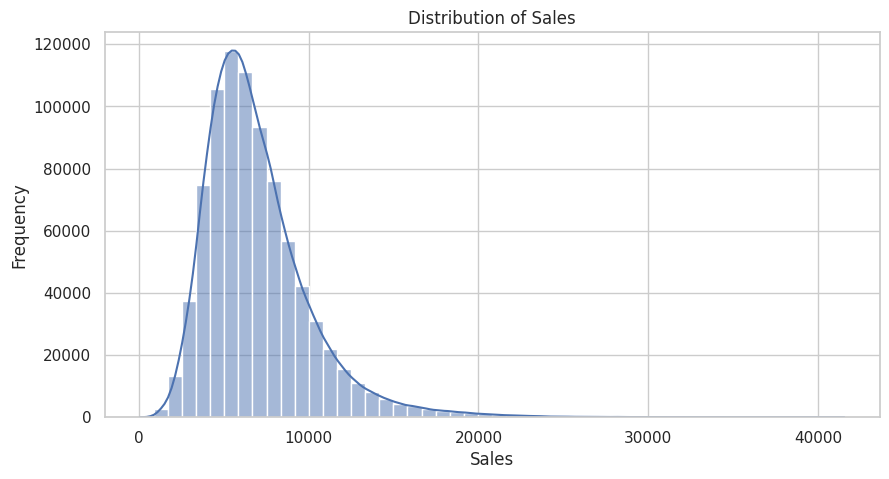

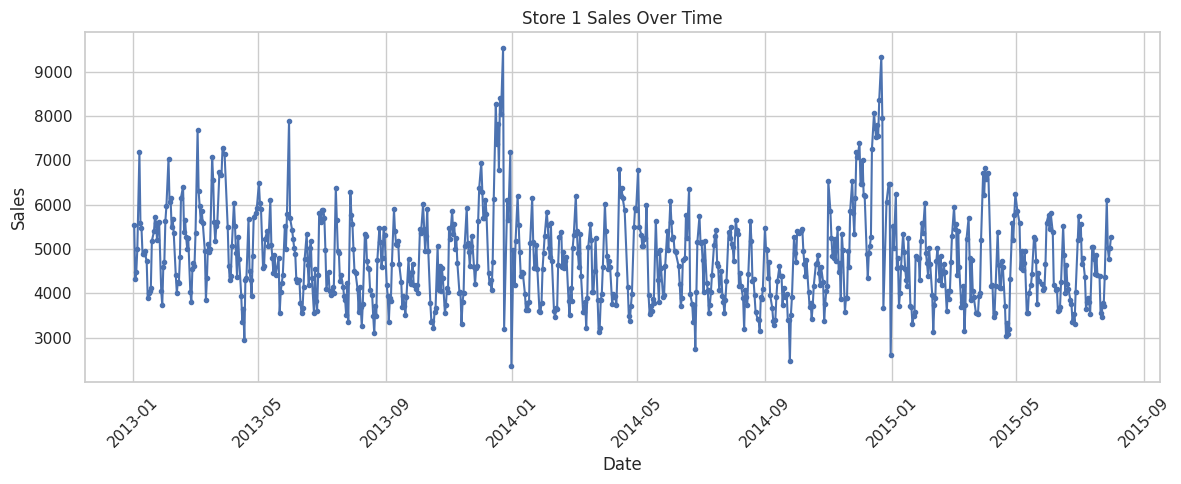

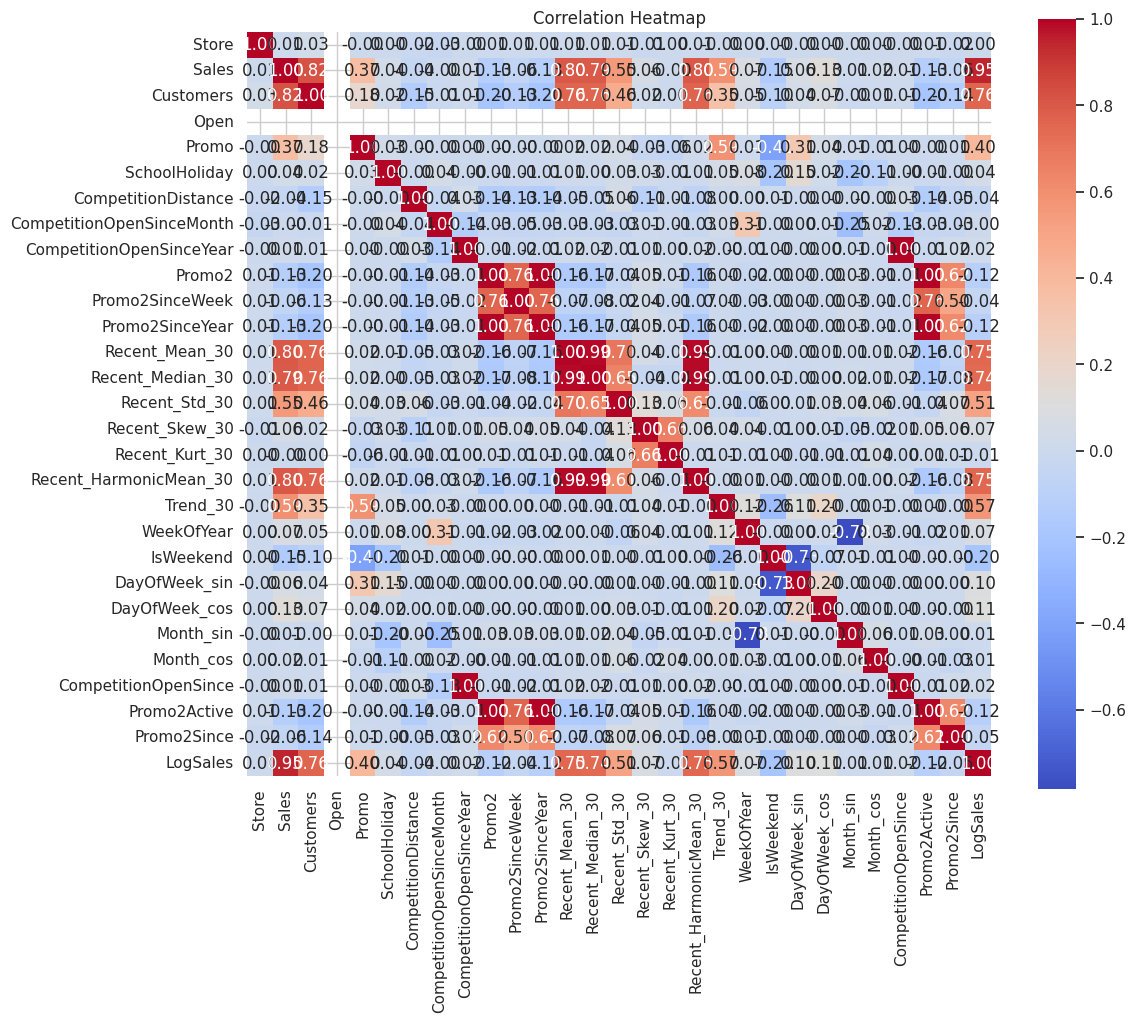

Data split into training and internal testing sets.
Training the XGBoost model...
Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best parameters found: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
Best RMSE (negative): -0.2347804968146392
Evaluating model on internal test set...
Internal Test Evaluation Metrics:
RMSE: 0.24
MAE: 0.18
MAPE: 2.07%


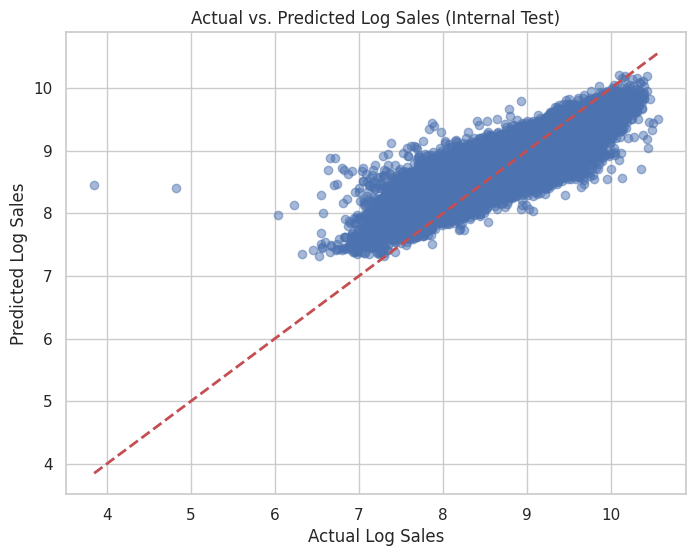

Model saved to xgb_rossmann_model.json
Pipeline completed.


In [15]:
main()

In [ ]:

def load_and_evaluate_external_new():
    """
    Loads a previously trained XGBoost model and evaluates it on external test set.
    """
    # Load model
    model = xgb.XGBRegressor()
    model.load_model('xgb_rossmann_model_new.json')
    print("Model loaded from xgb_rossmann_model_new.json")
    return model

In [ ]:
model_new = load_and_evaluate_external_new()

In [ ]:
def evaluate_test_data_new(model, merged_test_df):
    """
    Evaluates the external test dataframe (already merged with store data)
    using the trained model.

    This function applies the same preprocessing and feature engineering steps
    as used in training. It then drops columns that are not used for prediction
    (including 'Customers', since it is not available in future data) and returns
    model predictions.

    Args:
      model: Trained XGBoost model.
      merged_test_df (DataFrame): Merged test data (test.csv merged with store.csv).

    Returns:
      preds (ndarray): Model predictions.
    """
    # Apply the same preprocessing and feature engineering
    test_clean = preprocess_data(merged_test_df)
    test_fe = feature_engineering_new(test_clean)

    # Build the list of columns to drop from test data;
    # note: we drop 'Id', 'Date', 'Sales', 'LogSales', and importantly 'Customers'
    drop_cols = ['Id', 'Sales', 'Date', 'LogSales', 'Customers']
    X_test = test_fe.drop(columns=[col for col in drop_cols if col in test_fe.columns], errors='ignore')

    # Ensure only numeric features are used (and the order of columns matches training)
    X_test = X_test.select_dtypes(include=[np.number])

    # Get predictions from the model
    preds = model.predict(X_test)

    predictions = model.predict(X_test)
    return preds

In [ ]:
print("Loading and merging external test data...")
test_df = pd.read_csv('test.csv', parse_dates=['Date'])
store = pd.read_csv('store.csv')
external_merged = pd.merge(test_df, store, on='Store', how='left')

In [ ]:
print("Evaluating external test data...")
evaluate_test_data_new(model_new, external_merged)

In [ ]:
# prompt: create submission.csv with the same formatting as sample_submission using the pred array returned from the evaluate_test_data function from the last cell

import pandas as pd
import numpy as np

# Assuming 'evaluate_test_data' and 'external_merged' are defined from the previous cell
pred = evaluate_test_data_new(model_new, external_merged)

# Create a DataFrame for submission
submission_df = pd.DataFrame({'Id': external_merged['Id'], 'Sales': np.expm1(pred)})

# Save to submission.csv
submission_df.to_csv('submission_better.csv', index=False)
